In [ ]:
# @title Install Necessary Libraries

# Install required packages
!pip install --upgrade pylibjpeg pylibjpeg-libjpeg pydicom pillow
!pip install opencv-python matplotlib
!pip install numpy==1.24.3
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the SAM model checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.4 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.
py

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rk9kok3k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rk9kok3k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-11-04 00:31:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   230MB/s    in 12s     

2024-11-04 00:31:54 (198 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [ ]:
# @title Import Libraries

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom
import pandas as pd
from segment_anything import sam_model_registry, SamPredictor
import itertools
from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True


In [ ]:
# Mount the Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Load the SAM Model

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the SAM model
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device)
predictor = SamPredictor(sam)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# @title Define Helper Functions
# @title Import Libraries
import cv2
import os
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy as scipy_entropy
from PIL import Image
import numpy as np
from skimage.filters.rank import entropy as skimage_entropy
from skimage.morphology import disk
from skimage import img_as_ubyte

def show_box(box, ax, edgecolor='green'):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor='none', lw=3))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Dodger blue
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def apply_clahe_to_array(image_array, clip_limit, tile_grid_size):
    #print(f"Applying CLAHE with clipLimit={clip_limit}, tileGridSize={tile_grid_size}")
    # Normalize image to 0-255 and convert to uint8
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=5)
    # Apply CLAHE
    clahe_image = clahe.apply(image_array) + 30
    return clahe_image

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    else:
        return intersection / union

def apply_canny_to_array(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    otsu_threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lower_threshold = int(otsu_threshold * 0.1)
    upper_threshold = int(otsu_threshold * 0.5)
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    combined_image = cv2.addWeighted(image, 0.3, edges, 0.7, 0)
    return combined_image

def visualize_mask_on_image(image, mask, title="Mask on Image"):
    plt.figure(figsize=(8, 8))

    # Create a copy of the image to overlay the mask
    image_with_mask = image.copy()

    # Color the mask in red and overlay it on the original image
    red_mask = np.zeros_like(image_with_mask)
    red_mask[..., 0] = mask * 255  # Red channel

    # Blend the original image with the red mask
    blended = cv2.addWeighted(image_with_mask, 0.7, red_mask, 0.3, 0)

    # Display the result
    plt.imshow(blended)
    plt.title(title)
    plt.axis('off')
    plt.show()

def calculate_entropy(image):
    # Flatten the image array to 1D
    image_flat = image.flatten()

    # Count frequency of pixel values
    histogram, _ = np.histogram(image_flat, bins=256, range=(0, 256), density=True)

    # Calculate entropy
    return scipy_entropy(histogram)

def apply_entropy_filter(image, disk_radius):
    # Define a local neighborhood for the entropy filter using a disk of variable radius
    neighborhood = disk(disk_radius)

    # Apply the entropy filter
    entropy_image = skimage_entropy(image, neighborhood)

    # Rescale the entropy image for better visualization (0-255 range)
    entropy_image_rescaled = img_as_ubyte(entropy_image / entropy_image.max())

    return entropy_image_rescaled

def modify_bounding_boxes(boxes, translation_range=5, scale_range=0.1):
    modified_boxes = []

    for box in boxes:
        for i in range(4):
          # Extract coordinates
          x1, y1, x2, y2 = box

          # Apply random translation
          tx = np.random.randint(-translation_range, translation_range + 1)
          ty = np.random.randint(-translation_range, translation_range + 1)

          # Apply random scaling
          scale_factor = 1 + np.random.uniform(-scale_range, scale_range)
          width = x2 - x1
          height = y2 - y1
          new_width = width * scale_factor
          new_height = height * scale_factor

          # Calculate new coordinates
          new_x1 = int(x1 + tx)
          new_y1 = int(y1 + ty)
          new_x2 = int(new_x1 + new_width)
          new_y2 = int(new_y1 + new_height)

          modified_boxes.append([new_x1, new_y1, new_x2, new_y2])
          #print(modified_boxes)

    return np.array(modified_boxes)


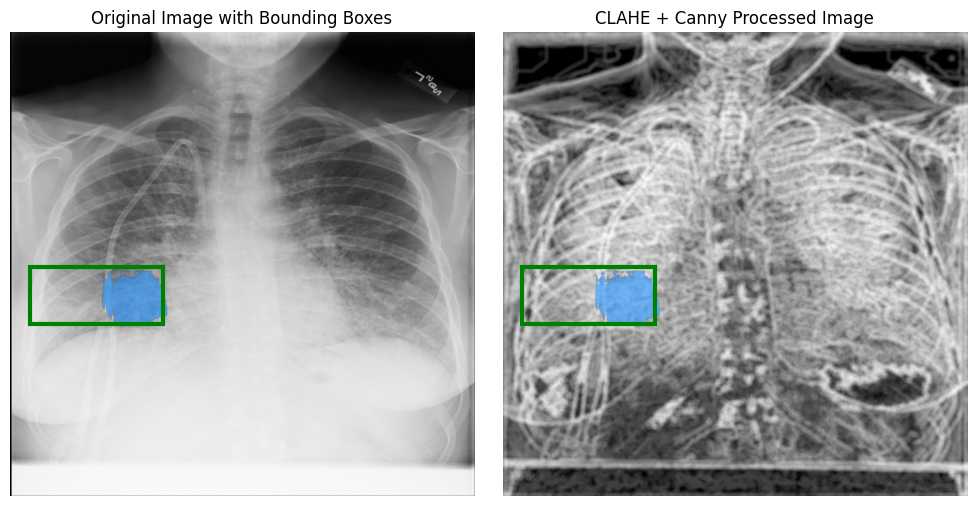

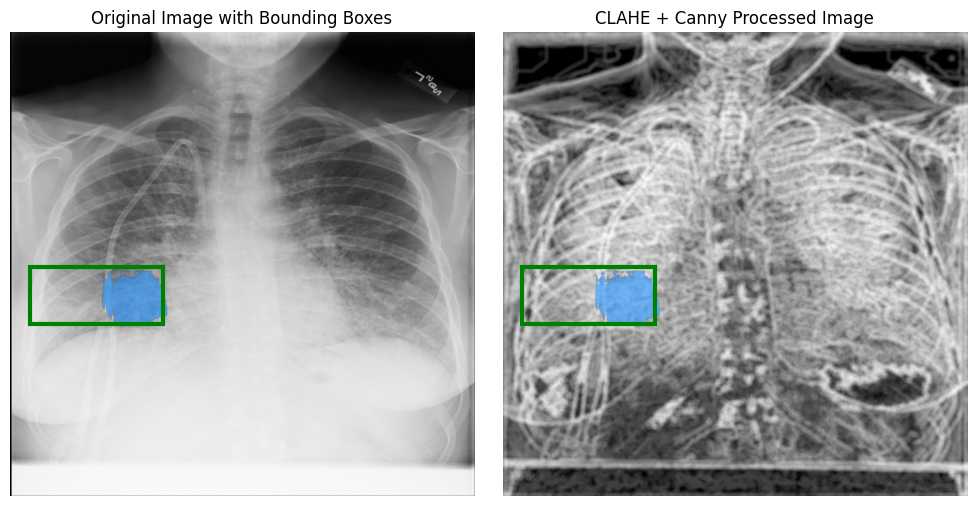

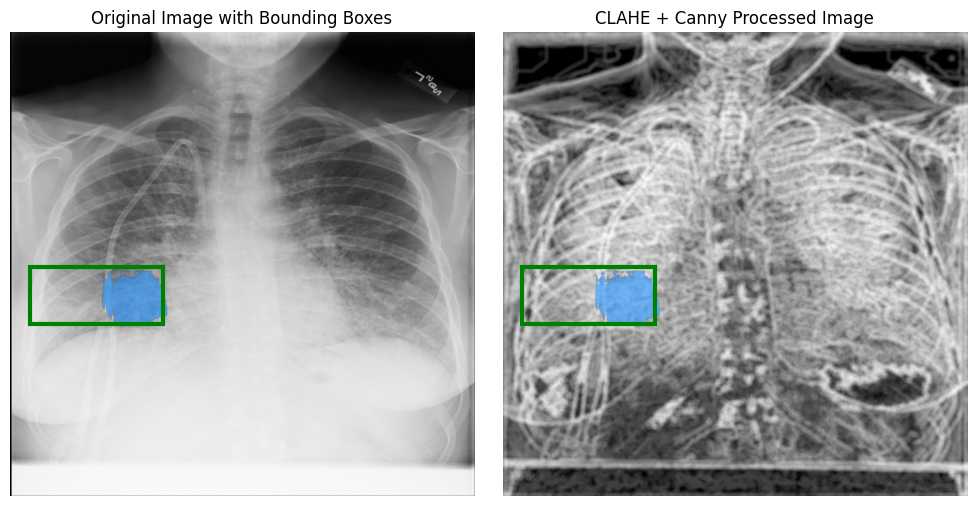

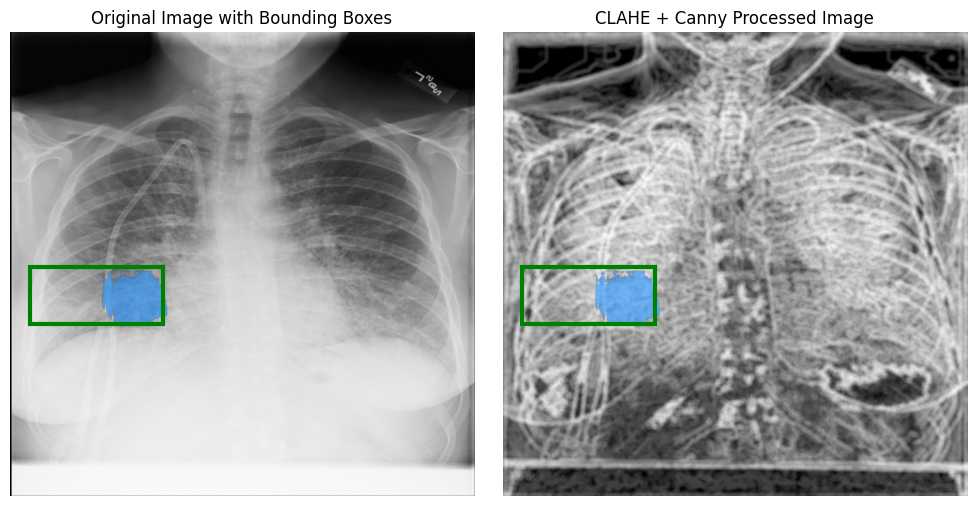

[0.71485972 0.71485972 0.71485972 0.71485972 0.         0.
 0.         0.        ]
Mean SAM Score (with CLAHE + Canny + Blur + Entropy): 0.3574298620223999
Mean IoU Score (with CLAHE + Canny + Blur + Entropy): 0.3468073113777277
Consistency Score: (0.0, 0.0)


In [ ]:
# @title Process Images and Compare Masks
%matplotlib inline
from PIL import Image
import glob
from pathlib import Path
import pandas as pd
import pydicom
from itertools import zip_longest
# Initialize lists to hold IoU scores and SAM scores

modified_boxes = np.zeros(shape=(40,4,4))
sam_scores = np.zeros(shape=(40,4))
consistency_scores = np.zeros(shape=(40))
index = 0
images = glob.glob('/content/drive/MyDrive/SAM2_boundingBox/*/*.png')
images = images[40:60]
bounding_boxes_dict=pd.read_csv('/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_train_data.csv')
patients = list(bounding_boxes_dict.iterrows())
cln_imgs = glob.glob('/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/*')

for image in images:
    box_arr = np.zeros(shape=(8,4))
    ious_with_clahe_canny = []
    sam_scores_with_clahe_canny = np.zeros(shape=(8))
    consistency_score = 12

    patient_id = Path(image).stem[:-10]

    boxes = []  # Initialize an empty list to hold multiple bounding boxes
    pid = None

    for img in cln_imgs:
        if patient_id in img:
            dicom_image = pydicom.dcmread(img)
            image = dicom_image.pixel_array
            break

    # Iterate over the rows of the DataFrame
    for _, row in patients:
        # Access the patient ID column (replace with the actual column name for patient ID)
        pid = row['patientId']  # Replace with actual patient ID column name

        # Check if the patient_id matches the one in the DataFrame
        if patient_id == pid:
            # Collect the bounding box coordinates (replace with actual column names if necessary)
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            # Append the bounding box as a tuple
            boxes.append((x1, y1, x2, y2))
            break

    if boxes is None:
            break

    boxes = modify_bounding_boxes(boxes)
    #print("BOXES: ", boxes.shape)

    # Apply best CLAHE
    clahe_image = apply_clahe_to_array(
        image,
        clip_limit=1.0,
        tile_grid_size=(32,32)
    )

    # Apply Canny and blur to CLAHE
    clahe_canny_image = apply_canny_to_array(
        clahe_image
    )

    # Apply entropy to Canny and CLAHE
    clahe_canny_image = apply_entropy_filter(clahe_canny_image, 7)

    # Convert images to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)

    # Process CLAHE CANNY ENTROPY AND BLUR
    predictor.set_image(clahe_canny_image_rgb)

    for box, i in zip(boxes, range(8)):
        box_arr[i] = box
        input_box = np.array(box)
        #print(input_box)
        #print(input_box[None, :])
        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=True
        )
        # Select the mask with the highest score
        best_idx = np.argmax(scores)
        best_mask = masks[best_idx]
        best_score = scores[best_idx]

        sam_scores_with_clahe_canny[i] = best_score

        #visualize_mask_on_image(clahe_canny_image_rgb, best_mask, title="Best Mask With CLAHE and Canny")

        # Create approximate ground truth mask from bounding box
        gt_mask = np.zeros(clahe_canny_image.shape, dtype=np.uint8)
        x1, y1, x2, y2 = map(int, box)
        gt_mask[y1:y2, x1:x2] = 1

        # Compute IoU between predicted mask and ground truth mask
        iou = compute_iou(best_mask, gt_mask)
        ious_with_clahe_canny.append(iou)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the original image with bounding boxes
        axs[0].imshow(image_rgb)
        axs[0].set_title('Original Image with Bounding Boxes')
        axs[0].axis('off')

        # Display the CLAHE + Canny processed image
        axs[1].imshow(clahe_canny_image_rgb, cmap='gray')
        axs[1].set_title('CLAHE + Canny Processed Image')
        axs[1].axis('off')

        # Draw bounding boxes on the original image
        for box in boxes:
            show_box(box, axs[0])
            show_box(box, axs[1])
            # Overlay the mask on both images
            show_mask(best_mask, axs[0])  # Original image
            show_mask(best_mask, axs[1])  # CLAHE + Canny image

            # Overlay the mask on the CLAHE + Canny processed image

            plt.tight_layout()
            #plt.savefig(f"/content/drive/MyDrive/canny_only/{patient_id}.png")
            plt.show()
            plt.close()
            break

    print(sam_scores_with_clahe_canny)

    for j in range(4):  # Loop through the 4 perturbations
        modified_boxes[index][j] = box_arr[j]  # First 4 boxes to even indices
        modified_boxes[index + 1][j] = box_arr[j + 4]  # Last 4 boxes to odd indices
        sam_scores[index][j] = sam_scores_with_clahe_canny[j]  # First 4 scores to even indices
        sam_scores[index + 1][j] = sam_scores_with_clahe_canny[j + 4]  # Last 4 scores to odd indices

    consistency_score = np.std(sam_scores[index])  # Inverse of standard deviation
    consistency_scores[index] = consistency_score
    consistency_score = np.std(sam_scores[index + 1])  # Inverse of standard deviation
    consistency_scores[index + 1] = consistency_score

        # Calculate and print the mean IoU scores

    mean_iou_with_clahe_canny = np.mean(ious_with_clahe_canny)
    mean_sam_with_clahe_canny = np.mean(sam_scores_with_clahe_canny)
    print(f"Mean SAM Score (with CLAHE + Canny + Blur + Entropy): {mean_sam_with_clahe_canny}")
    print(f"Mean IoU Score (with CLAHE + Canny + Blur + Entropy): {mean_iou_with_clahe_canny}")
    print(f"Consistency Score: {consistency_scores[index], consistency_scores[index + 1]}")
    break
    index += 2

    if(index == 18):
      break

Non-Linear Regression Model

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Function to train a non-linear regression model
def train_regression_model(modified_boxes, sam_scores, consistency_scores):
    # Combine modified boxes and SAM scores as features
    X = np.hstack([modified_boxes, sam_scores.reshape(-1, 1)])  # Add SAM scores as a feature

    # Initialize and train the regression model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X, consistency_scores)

    return model

# Function to predict consistency scores
def predict_consistency(model, modified_boxes, sam_scores):
    X_new = np.hstack([modified_boxes, sam_scores.reshape(-1, 1)])
    predictions = model.predict(X_new)
    return predictions

In [ ]:
trained_model = train_regression_model(modified_boxes, sam_scores, consistency_scores)
print(predict_consistency(trained_model, modified_boxes, sam_scores))

[0.02561119 0.         0.02434109 0.         0.01775435 0.
 0.01650057 0.         0.01570979 0.         0.00708453 0.
 0.01527233 0.         0.01080621 0.         0.01232315 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [ ]:
print(predict_consistency(trained_model, modified_boxes, sam_scores))

[0.01927432 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
